# Tutorial: Two dimensional Wave problem with hard constraint

In this tutorial we present how to solve the wave equation using hard constraint PINNs. For doing so we will build a costum `torch` model and pass it to the `PINN` solver.

First of all, some useful imports.

In [1]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import laplacian, grad
from pina.geometry import CartesianDomain
from pina.solvers import PINN
from pina.trainer import Trainer
from pina.equation import Equation
from pina.equation.equation_factory import FixedValue
from pina import Condition, Plotter

## The problem definition 

The problem is written in the following form:

\begin{equation}
\begin{cases}
\Delta u(x,y,t) = \frac{\partial^2}{\partial t^2} u(x,y,t) \quad \text{in } D, \\\\
u(x, y, t=0) = \sin(\pi x)\sin(\pi y), \\\\
u(x, y, t) = 0 \quad \text{on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}

where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square, and the velocity in the standard wave equation is fixed to one.

Now, the wave problem is written in PINA code as a class, inheriting from `SpatialProblem` and `TimeDependentProblem` since we deal with spatial, and time dependent variables. The equations are written as `conditions` that should be satisfied in the corresponding domains. `truth_solution` is the exact solution which will be compared with the predicted one.

In [2]:
class Wave(TimeDependentProblem, SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})
    temporal_domain = CartesianDomain({'t': [0, 1]})

    def wave_equation(input_, output_):
        u_t = grad(output_, input_, components=['u'], d=['t'])
        u_tt = grad(u_t, input_, components=['dudt'], d=['t'])
        nabla_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])
        return nabla_u - u_tt

    def initial_condition(input_, output_):
        u_expected = (torch.sin(torch.pi*input_.extract(['x'])) *
                      torch.sin(torch.pi*input_.extract(['y'])))
        return output_.extract(['u']) - u_expected

    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [0, 1], 'y':  1, 't': [0, 1]}), equation=FixedValue(0.)),
        'gamma2': Condition(location=CartesianDomain({'x': [0, 1], 'y': 0, 't': [0, 1]}), equation=FixedValue(0.)),
        'gamma3': Condition(location=CartesianDomain({'x':  1, 'y': [0, 1], 't': [0, 1]}), equation=FixedValue(0.)),
        'gamma4': Condition(location=CartesianDomain({'x': 0, 'y': [0, 1], 't': [0, 1]}), equation=FixedValue(0.)),
        't0': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1], 't': 0}), equation=Equation(initial_condition)),
        'D': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1], 't': [0, 1]}), equation=Equation(wave_equation)),
    }

    def wave_sol(self, pts):
        return (torch.sin(torch.pi*pts.extract(['x'])) *
                torch.sin(torch.pi*pts.extract(['y'])) *
                torch.cos(torch.sqrt(torch.tensor(2.))*torch.pi*pts.extract(['t'])))

    truth_solution = wave_sol

problem = Wave()

## Hard Constraint Model

After the problem, a **torch** model is needed to solve the PINN. Usually, many models are already implemented in **PINA**, but the user has the possibility to build his/her own model in `torch`. The hard constraint we impose is on the boundary of the spatial domain. Specifically, our solution is written as:

$$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t), $$

where $NN$ is the neural net output. This neural network takes as input the coordinates (in this case $x$, $y$ and $t$) and provides the unknown field $u$. By construction, it is zero on the boundaries. The residuals of the equations are evaluated at several sampling points (which the user can manipulate using the method `discretise_domain`) and the loss minimized by the neural network is the sum of the residuals.

In [3]:
class HardMLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, 40),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(40, 40),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(40, output_dim))
        
    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard = x.extract(['x'])*(1-x.extract(['x']))*x.extract(['y'])*(1-x.extract(['y']))
        return hard*self.layers(x)

## Train and Inference

In this tutorial, the neural network is trained for 1000 epochs with a learning rate of 0.001 (default in `PINN`). Training takes approximately 3 minutes.

In [4]:
# generate the data
problem.discretise_domain(1000, 'random', locations=['D', 't0', 'gamma1', 'gamma2', 'gamma3', 'gamma4'])

# crete the solver
pinn = PINN(problem, HardMLP(len(problem.input_variables), len(problem.output_variables)))

# create trainer and train
trainer = Trainer(pinn, max_epochs=1000, accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/dariocoscia/Desktop/PINA/tutorials/tutorial3/lightning_logs


Epoch 999: : 1it [00:00, 62.13it/s, v_num=0, mean_loss=0.0268, D_loss=0.0397, t0_loss=0.121, gamma1_loss=0.000, gamma2_loss=0.000, gamma3_loss=0.000, gamma4_loss=0.000] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: : 1it [00:00, 53.88it/s, v_num=0, mean_loss=0.0268, D_loss=0.0397, t0_loss=0.121, gamma1_loss=0.000, gamma2_loss=0.000, gamma3_loss=0.000, gamma4_loss=0.000]


Notice that the loss on the boundaries of the spatial domain is exactly zero, as expected! After the training is completed one can now plot some results using the `Plotter` class of **PINA**.

Plotting at t=0


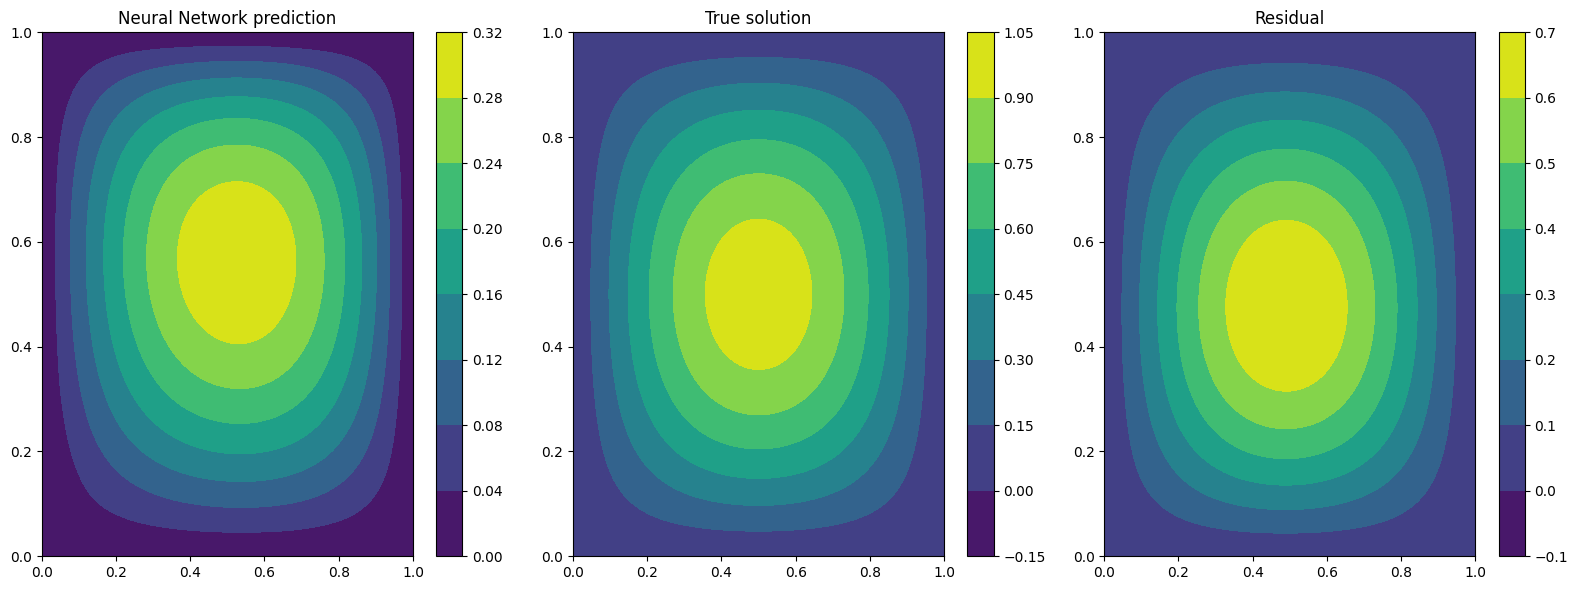

Plotting at t=0.5


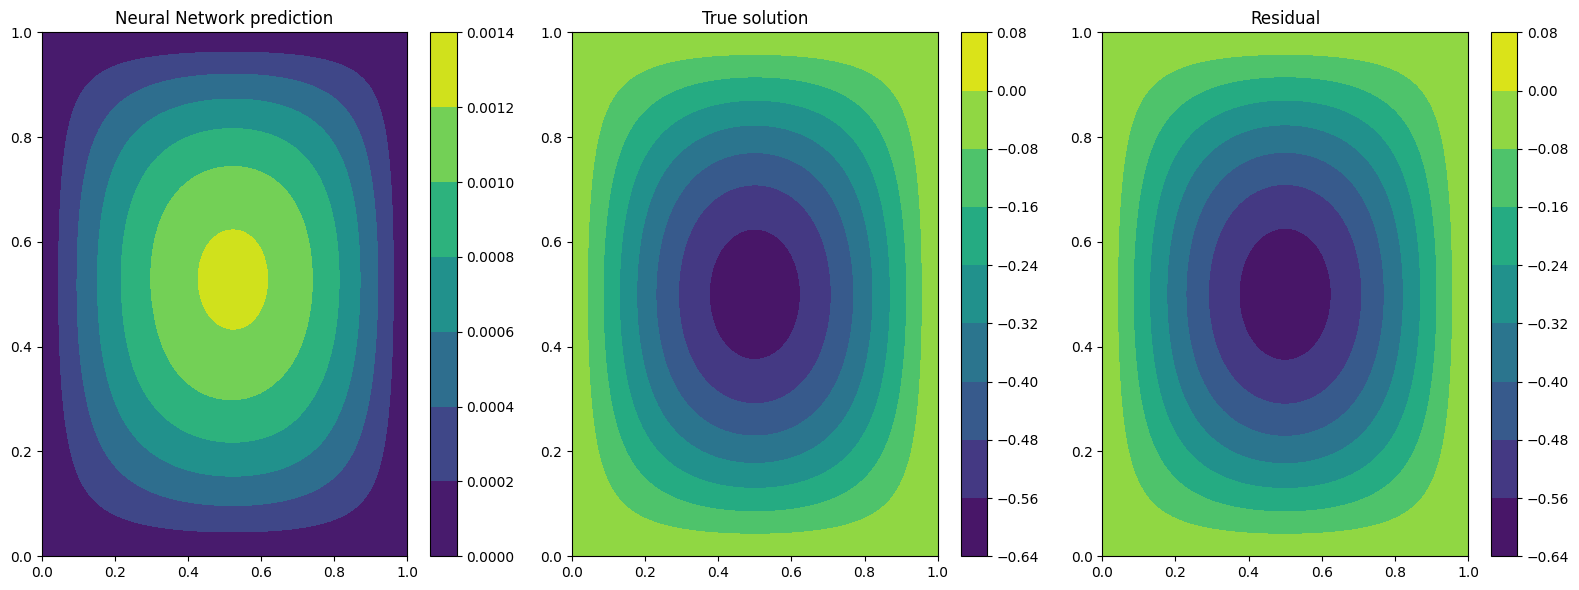

Plotting at t=1


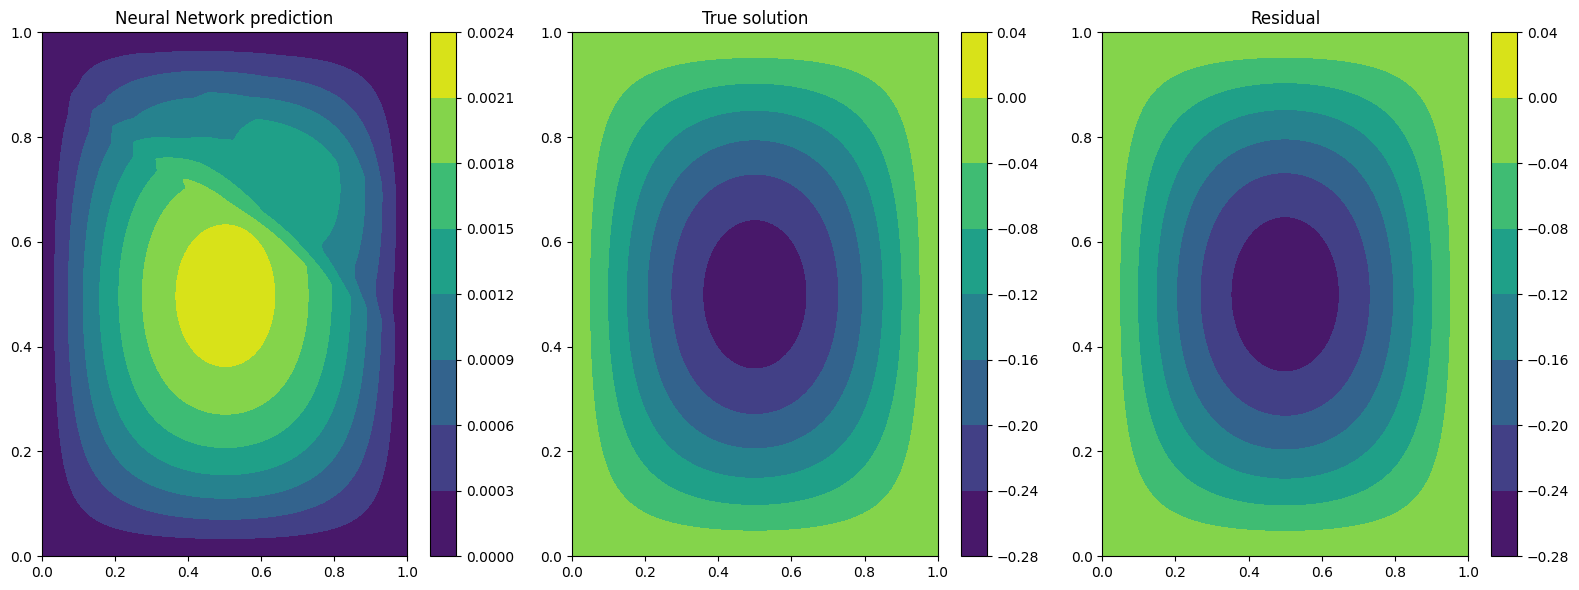

In [5]:
plotter = Plotter()

# plotting at fixed time t = 0.0
print('Plotting at t=0')
plotter.plot(pinn, fixed_variables={'t': 0.0})

# plotting at fixed time t = 0.5
print('Plotting at t=0.5')
plotter.plot(pinn, fixed_variables={'t': 0.5})

# plotting at fixed time t = 1.
print('Plotting at t=1')
plotter.plot(pinn, fixed_variables={'t': 1.0})

The results are not so great, and we can clearly see that as time progress the solution get worse.... Can we do better?

A valid option is to impose the initial condition as hard constraint as well. Specifically, our solution is written as:

$$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t)\cdot t + \cos(\sqrt{2}\pi t)sin(\pi x)\sin(\pi y), $$

Let us build the network first

In [6]:
class HardMLPtime(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, 40),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(40, 40),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(40, output_dim))
        
    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard_space = x.extract(['x'])*(1-x.extract(['x']))*x.extract(['y'])*(1-x.extract(['y']))
        hard_t = torch.sin(torch.pi*x.extract(['x'])) * torch.sin(torch.pi*x.extract(['y'])) * torch.cos(torch.sqrt(torch.tensor(2.))*torch.pi*x.extract(['t']))
        return hard_space * self.layers(x) * x.extract(['t']) + hard_t

Now let's train with the same configuration as thre previous test

In [7]:
# generate the data
problem.discretise_domain(1000, 'random', locations=['D', 't0', 'gamma1', 'gamma2', 'gamma3', 'gamma4'])

# crete the solver
pinn = PINN(problem, HardMLPtime(len(problem.input_variables), len(problem.output_variables)))

# create trainer and train
trainer = Trainer(pinn, max_epochs=1000, accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 999: : 1it [00:00, 48.54it/s, v_num=1, mean_loss=1.48e-8, D_loss=8.89e-8, t0_loss=0.000, gamma1_loss=2.06e-15, gamma2_loss=0.000, gamma3_loss=2.1e-15, gamma4_loss=0.000]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: : 1it [00:00, 43.25it/s, v_num=1, mean_loss=1.48e-8, D_loss=8.89e-8, t0_loss=0.000, gamma1_loss=2.06e-15, gamma2_loss=0.000, gamma3_loss=2.1e-15, gamma4_loss=0.000]


We can clearly see that the loss is way lower now. Let's plot the results

Plotting at t=0


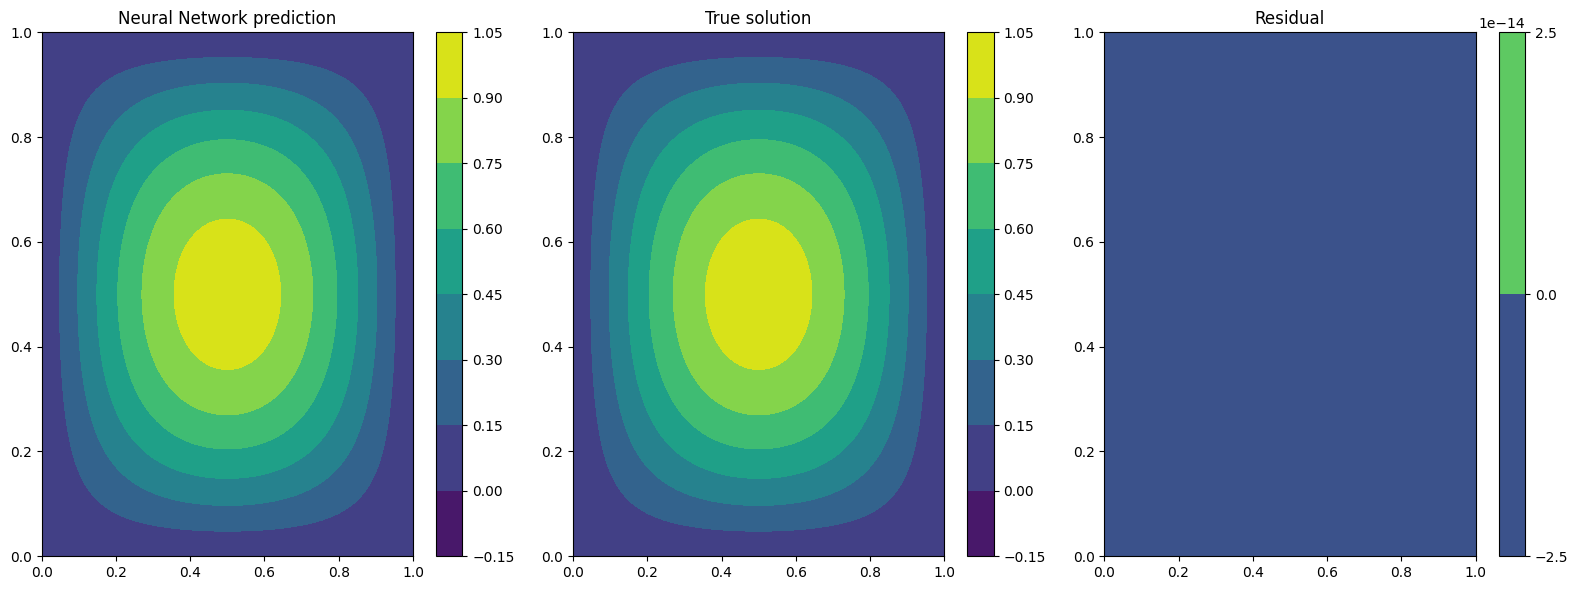

Plotting at t=0.5


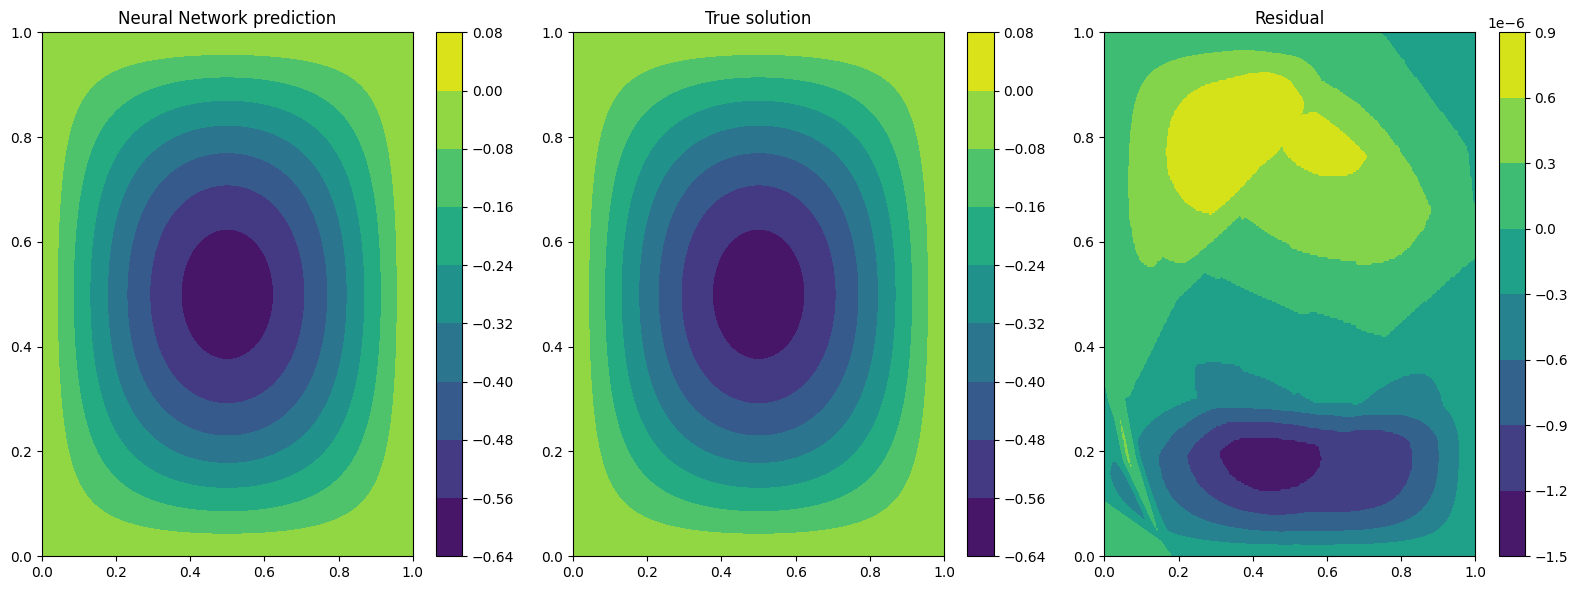

Plotting at t=1


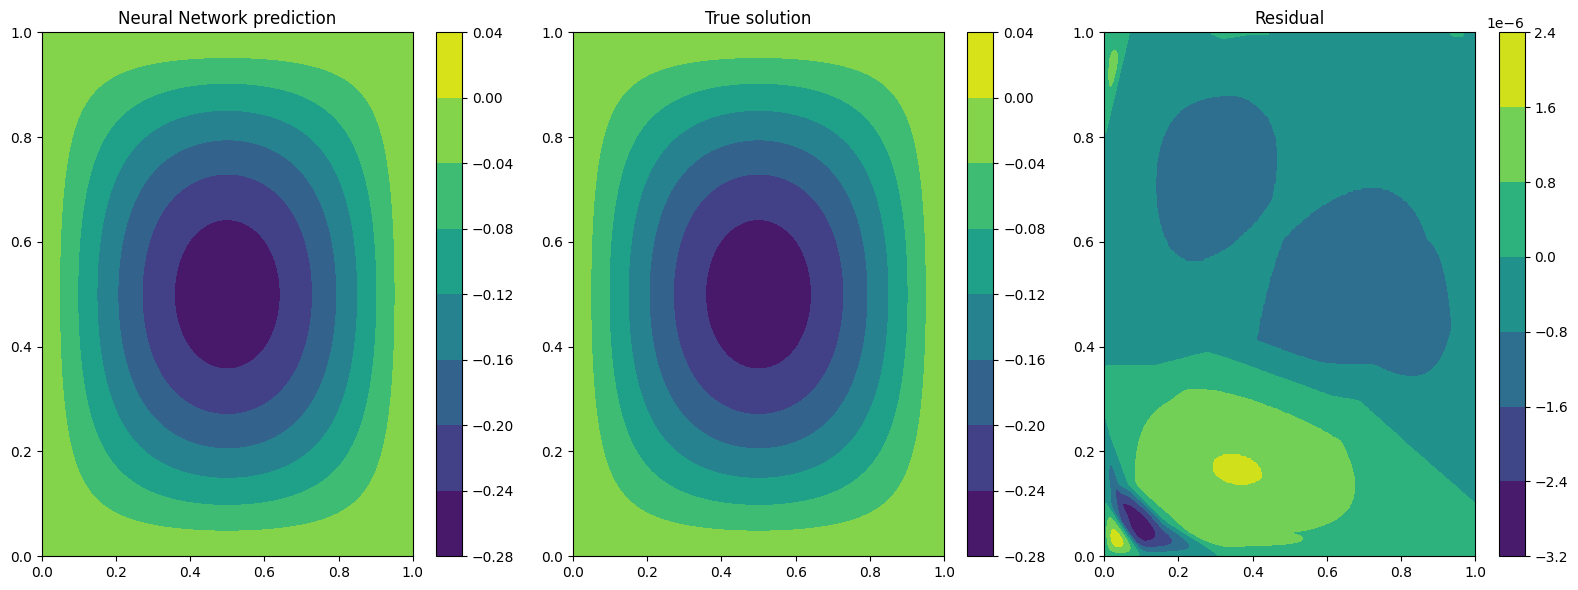

In [8]:
plotter = Plotter()

# plotting at fixed time t = 0.0
print('Plotting at t=0')
plotter.plot(pinn, fixed_variables={'t': 0.0})

# plotting at fixed time t = 0.5
print('Plotting at t=0.5')
plotter.plot(pinn, fixed_variables={'t': 0.5})

# plotting at fixed time t = 1.
print('Plotting at t=1')
plotter.plot(pinn, fixed_variables={'t': 1.0})

We can see now that the results are way better! This is due to the fact that previously the network was  not learning correctly the initial conditon, leading to a poor solution when the time evolved. By imposing the initial condition the network is able to correctly solve the problem.

## What's next?

Nice you have completed the two dimensional Wave tutorial of **PINA**! There are multiple directions you can go now:

1. Train the network for longer or with different layer sizes and assert the finaly accuracy

2. Propose new types of hard constraints in time, e.g. $$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t)(1-\exp(-t)) + \cos(\sqrt{2}\pi t)sin(\pi x)\sin(\pi y), $$

3. Exploit extrafeature training for model 1 and 2

4. Many more...